In [17]:
import gym
import numpy as np
import gc
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from collections import deque
import random
import matplotlib.pyplot as plt

In [18]:
env = gym.make('MountainCar-v0')
state = env.reset()
state

array([-0.49709418,  0.        ], dtype=float32)

In [19]:
model = tf.keras.Sequential([Dense(64, activation='relu', input_shape=(2,)), Dense(3)])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________


In [20]:
gamma = 0.99
episodes = 500

In [21]:
def train(model, optimizer, states, actions, log_probs, rewards):
    T = len(rewards)
    rets = np.empty(T, dtype=np.float32) # the returns
    future_ret = 0.0
    # compute the returns efficiently
    for t in reversed(range(T)):
        future_ret = rewards[t] + gamma * future_ret
        rets[t] = future_ret
    rets = tf.convert_to_tensor(rets)
    log_probs = tf.convert_to_tensor(log_probs)
    with tf.GradientTape() as tape:
        pdparam = model(tf.convert_to_tensor(np.vstack(states), dtype=tf.float32))
        pd = tf.keras.activations.softmax(pdparam, axis=-1)
        selected_actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        selected_probs = tf.gather_nd(pd, tf.stack([tf.range(len(actions)), selected_actions], axis=-1))
        loss = -tf.reduce_sum(tf.math.log(selected_probs) * rets)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [22]:
Rewards = []

for epi in range(episodes):
  state = env.reset()
  log_probs = []
  rewards = []
  states = []
  actions = []
  max_state = -1.0
  for t in range(200):
      x = np.expand_dims(state.astype(np.float32), axis=0)
      pdparam = model(x)
      pd = tf.keras.activations.softmax(pdparam, axis =-1)
      action = np.random.choice(range(pd.shape[1]), p=pd.numpy().ravel())
      log_prob = tf.math.log(pd[:, action])
      log_probs.append(log_prob)

      states.append(state)
      actions.append(action)

      # print(action.item())
      state, reward, done, _ = env.step(action)
      # print(state, reward)

      if state[0] > max_state:
        max_state = state[0]
        reward = 1
      elif state[0]>=0.5 or max_state >= 0.5:
        reward = 200
        print("Car reached the goal")
        done = True  
      else:
        reward = -1
      
      rewards.append(reward)
      # env.render()
      if done:
          break

  # pi = nn.Sequential(*layers)
  model.log_probs = log_probs
  model.rewards = rewards

  loss = train(model, optimizer, states, actions, log_probs, rewards)
  total_reward = sum(rewards)
  Rewards.append(total_reward)

  print(f'Episode {epi+1}, total_reward: {total_reward}')

Episode 1, total_reward: -162
Episode 2, total_reward: -124
Episode 3, total_reward: -136
Episode 4, total_reward: -148
Episode 5, total_reward: -126
Episode 6, total_reward: -120
Episode 7, total_reward: -116
Episode 8, total_reward: -158
Episode 9, total_reward: -198
Episode 10, total_reward: -120
Episode 11, total_reward: -146
Episode 12, total_reward: -124
Episode 13, total_reward: -140
Episode 14, total_reward: -188
Episode 15, total_reward: -166
Episode 16, total_reward: -152
Episode 17, total_reward: -198
Episode 18, total_reward: -112
Episode 19, total_reward: -102
Episode 20, total_reward: -86
Episode 21, total_reward: -132
Episode 22, total_reward: -156
Episode 23, total_reward: -168
Episode 24, total_reward: -146
Episode 25, total_reward: -92
Episode 26, total_reward: -118
Episode 27, total_reward: -72
Episode 28, total_reward: -112
Episode 29, total_reward: -140
Episode 30, total_reward: -142
Episode 31, total_reward: -132
Episode 32, total_reward: -116
Episode 33, total_re

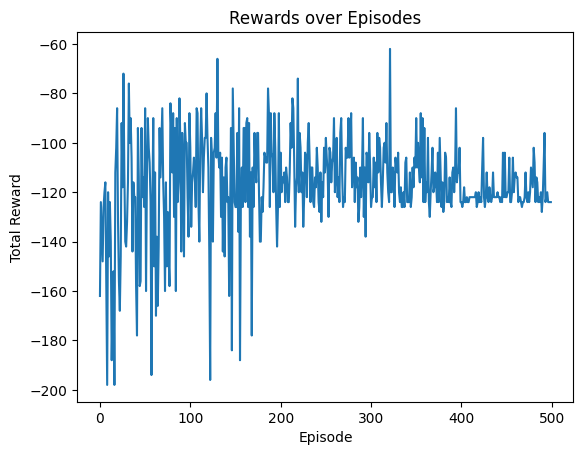

In [23]:
plt.plot(Rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()